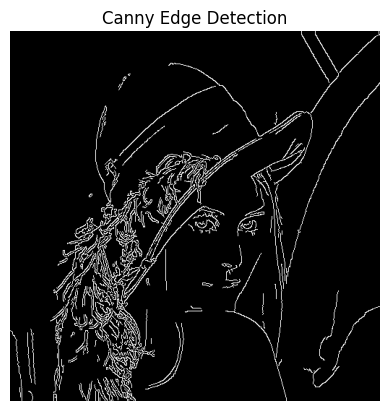

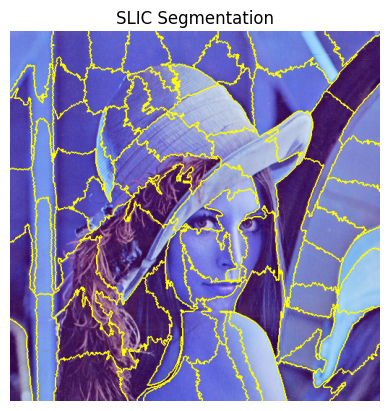

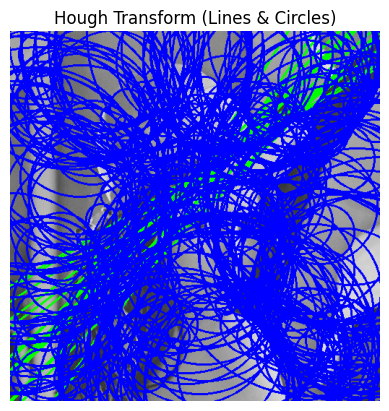

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-3-1 Python-3.11.11 torch-2.5.1+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 128MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


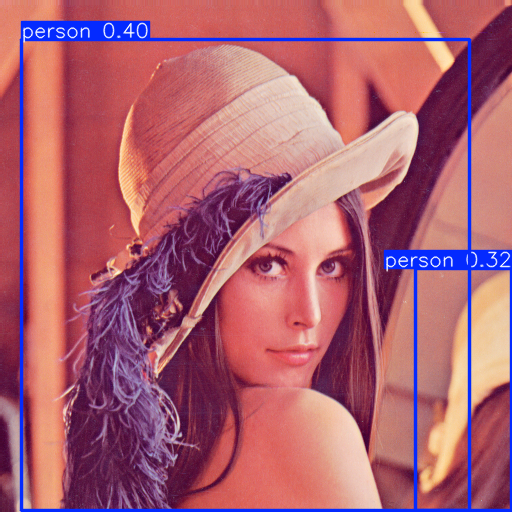

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s]



Faster R-CNN Detection Results:
Label: 1, Score: 0.98, Box: [66.01232147216797, 135.44496154785156, 401.0271911621094, 503.72320556640625]
Label: 1, Score: 0.84, Box: [404.17901611328125, 287.5860900878906, 509.47589111328125, 509.76708984375]
Label: 1, Score: 0.53, Box: [195.27706909179688, 163.51174926757812, 504.4807434082031, 512.0]


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
import torch
from torchvision import models, transforms
from PIL import Image

# ========================================
# Helper Function to Display Image
# ========================================
def show_image(title, image, cmap=None):
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ========================================
# 1.1 Edge-based Segmentation (Canny)
# ========================================
def edge_based_segmentation(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error: Could not load image at {image_path}")

    edges = cv2.Canny(image, 100, 200)
    show_image('Canny Edge Detection', edges, cmap='gray')

# ========================================
# 1.2 Region-based Segmentation using SLIC
# ========================================
def region_based_segmentation(image_path, n_segments=100):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Could not load image at {image_path}")

    segments = slic(image, n_segments=n_segments, compactness=10, start_label=1)
    show_image('SLIC Segmentation', mark_boundaries(image, segments))

# ========================================
# 1.3 Hough Transform (Lines & Circles)
# ========================================
def hough_transform(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error: Could not load image at {image_path}")

    edges = cv2.Canny(image, 50, 150)

    # Convert back to color for display
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Line detection
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
            x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
            cv2.line(result, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Circle detection
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(result, (i[0], i[1]), i[2], (255, 0, 0), 2)

    show_image('Hough Transform (Lines & Circles)', cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

# ========================================
# 2.1 Object Detection using YOLOv5 (Pretrained)
# ========================================
def object_detection_yolo(image_path):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)
    img = Image.open(image_path)
    results = model(img)
    results.show()

# ========================================
# 2.2 Object Detection using Faster R-CNN (Pretrained)
# ========================================
def object_detection_rcnn(image_path):
    # Use the latest version of pretrained weights
    model = models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    model.eval()

    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image_tensor)

    # Show results (simple text printout for now)
    print("\nFaster R-CNN Detection Results:")
    for box, label, score in zip(outputs[0]['boxes'], outputs[0]['labels'], outputs[0]['scores']):
        if score > 0.5:  # Filter out low-confidence detections
            print(f"Label: {label.item()}, Score: {score:.2f}, Box: {box.tolist()}")

# ========================================
# Main Function - Run All Tasks
# ========================================
def main(image_path):
    edge_based_segmentation(image_path)
    region_based_segmentation(image_path, n_segments=100)
    hough_transform(image_path)
    object_detection_yolo(image_path)
    object_detection_rcnn(image_path)

# ========================================
# Run Example
# ========================================
if __name__ == "__main__":
    image_path = '/content/Lena_Image.png'  # Change this to your actual image path
    main(image_path)
